In [1]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Synthetic data generation

In [3]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [4]:
import pandas as pd

In [5]:
# choice: 'basic', 'id'
synthesizer = 'basic'

## Load transactions

In [6]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [7]:
if synthesizer == 'id':
    data = data[['account_id', 'type', 'operation', 'amount']]
else:
    data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
if synthesizer == 'id':
    data['account_id'] = data['account_id'].astype(dtype='int32')
    id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
    data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [10]:
if synthesizer == 'id':
    from synthesized.core import IdSynthesizer
    synthesizer = IdSynthesizer
elif synthesizer == 'basic':
    from synthesized.core import BasicSynthesizer
    synthesizer = BasicSynthesizer

Instructions for updating:
Use the retry module or similar alternatives.


In [11]:
with synthesizer(dtypes=data.dtypes) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

5000: 7.39e+07
10000: 1.69e+08
15000: 1.49e+08
20000: 8.46e+07
25000: 8.37e+07
30000: 3.06e+07
35000: 1.59e+07
40000: 3.68e+06
45000: 8.51e+06
50000: 3.83e+06


## Display synthesized data

In [12]:
synthesized.head(10)

,amount,operation,type
0,8484.497070,3,0
1,23282.162109,2,1
2,4890.849609,3,0
3,6744.470703,3,0
4,9.703538,3,0
5,19993.175781,2,1
6,8251.837891,2,1
7,10645.012695,2,1
8,37485.398438,1,1
9,1790.107300,3,0


# Visualization of original and synthetic data

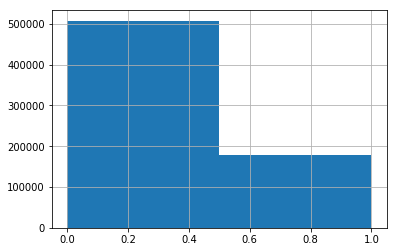

In [13]:
data['type'].hist(bins=2, range=[0, 1])

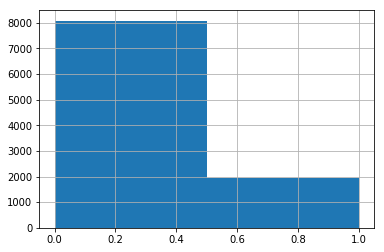

In [14]:
synthesized['type'].hist(bins=2, range=[0, 1])

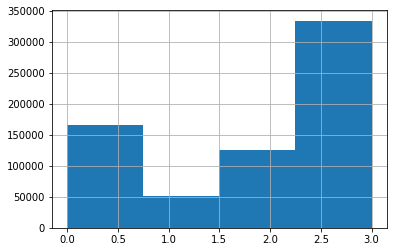

In [15]:
data['operation'].hist(bins=4, range=[0, 3])

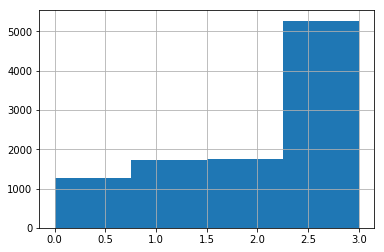

In [16]:
synthesized['operation'].hist(bins=4, range=[0, 3])

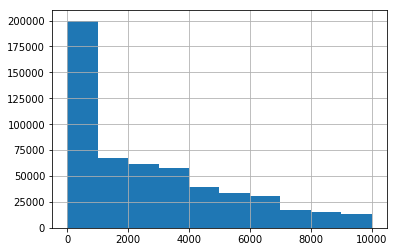

In [17]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

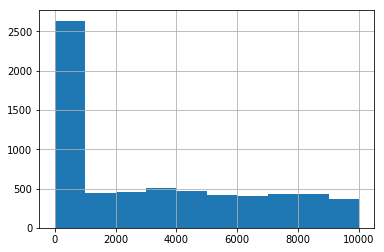

In [18]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [19]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [20]:
synthesized.head(5)

,amount,operation,type
0,8484.497070,3,0
1,23282.162109,2,1
2,4890.849609,3,0
3,6744.470703,3,0
4,9.703538,3,0


In [21]:
testing = Testing(data, test, cleared_df, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

NameError: name 'cleared_df' is not defined

In [ ]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

In [ ]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

In [ ]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

In [22]:
from synthesized.testing.linkage_attack import identify_attacks, Column, show_attacked_data, eradicate_attacks

In [23]:
data2 = data.head(30000)


In [24]:
schema = {
    'type': Column(key_attribute=False, sensitive=False, categorical=True),
    'operation': Column(key_attribute=False, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
}

In [25]:
len(data.amount.unique()) 

29646

In [26]:
attack = identify_attacks(data2, synthesized, schema)

In [29]:
len(attack)

294

In [38]:
show_attacked_data(data2, synthesized, attack[0], schema)

original df subset: 
          type  operation  amount
177477      0          3    14.6
488307      0          3    14.6
660051      0          3    14.6
565703      0          3    14.6
551065      0          3    14.6
329350      0          3    14.6
744700      0          3    14.6
469409      0          3    14.6
947697      0          3    14.6
369771      0          3    14.6
407893      0          3    14.6
200729      0          3    14.6
1001987     0          3    14.6
72034       0          3    14.6
206826      0          3    14.6
227041      0          3    14.6
40571       0          3    14.6
60575       0          3    14.6
762882      0          3    14.6
32419       0          3    14.6
6431        0          3    14.6
518175      0          3    14.6
932582      0          3    14.6
343365      0          3    14.6
810091      0          3    14.6
940935      0          3    14.6
219875      0          3    14.6
576305      0          3    14.6
1037504     0        

In [ ]:
cleared_df = eradicate_attacks(data2, synthesized, attack, schema)

remaining attacks :  294


/Users/nicolai/synthesized/synthesized/testing/testing_environment.py:213: RuntimeWarning:

invalid value encountered in true_divide

/Users/nicolai/synthesized/synthesized/testing/testing_environment.py:212: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
attack = identify_attacks(data2, synthesized, schema)

In [ ]:
len(attack)

In [ ]:
data2[(data2["amount"] <= 15) & (data2["amount"] > 13)]

In [ ]:
synthesized[(synthesized["amount"] <= 15) & (synthesized["amount"] > 13)]

In [61]:
synthesized

,amount,operation,type
0,7623.572754,3,0
1,9.653048,3,0
2,2693.866211,3,0
3,5325.477539,3,0
4,9.653048,3,0
5,6936.955078,3,1
6,4381.736328,3,0
7,8879.928711,3,0
8,23269.712891,3,1
9,533.191467,3,0
